<a href="https://colab.research.google.com/github/flaghunter21/DFS/blob/main/Contest_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Draftkings MLB Contest Analysis

In this project, we will be importing a raw Draftkings CSV file and player information to analyze the tendencies of the player population. The sample Draftkings CSV file is from the `$15 MLB $125K RELAY THROW [$25K TO 1ST]` contest on June 11, 2022. The player information was imported from FantasyCruncher's `Lineup Rewind` feature.

## Read in Data

The data was consolidated to one excel file with a `standings` sheet containing the results of the contest, and a `players` sheet containing the player information.

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
contest = pd.read_excel('colab_contest_analyzer.xlsx', sheet_name='standings').dropna()
contest.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup
0,1,3257533438,ihbrown3 (22/150),0,213.05,P Jordan Montgomery P Kyle Freeland OF Aaron J...
1,2,3257373692,BRORANNOSAURUS_FLEX (77/150),0,209.20,P Michael Lorenzen P Jordan Montgomery OF Shoh...
2,3,3257533499,ihbrown3 (83/150),0,198.05,P Jordan Montgomery P Kyle Freeland OF Aaron J...
3,4,3257484992,pianoclub (30/70),0,197.15,P Jordan Montgomery OF Aaron Judge OF Mike Tro...
4,5,3257062564,giantsquid (38/150),0,194.20,P Michael Lorenzen P Jordan Montgomery OF Shoh...


The contest file contains the following columns:
* `Rank` - A user's final ranking in the contest
* `EntryID` - Unique EntryID for each entry in the contest
* `EntryName` - Name of user
* `TimeRemaining` - Innings remaining in the lineup
* `Points` - Total points scored by the lineup
* `Lineup` - Each player and respective position in the lineup

In [4]:
players = pd.read_excel('colab_contest_analyzer.xlsx', sheet_name='players')
players.head()

,Player,Inj,Likes,Pos,Salary,Order,Hand,Team,Opp,Time,...,pGrade,Proj,My Proj,Exp.,Used,Con.,Value,Own%,Actual Score,Actual Val
0,MacKenzie Gore,NaN,NaN,P,10000,SP,L,SD,vs COL,15:10:00,...,A,21.030,21.030,100,0.779,56,2.1,0.5325,0.00,NaN
1,Carlos Carrasco,NaN,NaN,P,9400,SP,R,NYM,@ LAA,21:07:00,...,B,16.974,16.974,100,NaN,35,1.8,0.2591,8.50,0.9
2,Jordan Montgomery,NaN,NaN,P,7600,SP,L,NYY,vs CHC,18:15:00,...,B,16.243,16.243,100,NaN,66,2.1,0.3529,26.15,3.4
3,Clayton Kershaw,NaN,NaN,P,10000,SP,L,LAD,@ SF,18:15:00,...,C+,14.589,14.589,100,NaN,55,1.5,0.1307,10.00,1.0
4,George Kirby,NaN,NaN,P,7100,SP,R,SEA,vs BOS,21:10:00,...,B-,15.437,15.437,100,NaN,36,2.2,0.2929,9.05,1.3


There are many columns in the players file. The most important ones we will be using are as follows:
* `Player`
* `Salary` - The salary for the player in the contest
* `Order` - Batting order for the player in the lineup (1-9) or SP if Starting Pitcher
* `Team`
* `Own%` - The ownership of the player in the contest
* `Actual Score` - Fantasy points scored by player in the contest


## Data Cleaning

Looking at the contest file again below, we see all players included in one string in the Lineup column. We replace the player's position with commas and split these values on the comma character. Each player will be placed in their own column with the column name `FLEX1`, `FLEX2`, and so on.

In [5]:
contest.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup
0,1,3257533438,ihbrown3 (22/150),0,213.05,P Jordan Montgomery P Kyle Freeland OF Aaron J...
1,2,3257373692,BRORANNOSAURUS_FLEX (77/150),0,209.20,P Michael Lorenzen P Jordan Montgomery OF Shoh...
2,3,3257533499,ihbrown3 (83/150),0,198.05,P Jordan Montgomery P Kyle Freeland OF Aaron J...
3,4,3257484992,pianoclub (30/70),0,197.15,P Jordan Montgomery OF Aaron Judge OF Mike Tro...
4,5,3257062564,giantsquid (38/150),0,194.20,P Michael Lorenzen P Jordan Montgomery OF Shoh...


In [6]:
# Clean Lineup column
contest['Lineup'] = contest['Lineup'].str.replace(' P ',',') \
  .str.replace('P ','') \
  .str.replace(' C ',',') \
  .str.replace(' 1B ',',') \
  .str.replace(' 2B ',',') \
  .str.replace(' 3B ',',') \
  .str.replace(' SS ',',') \
  .str.replace(' OF ',',') \
  .str.replace('OF ','') \
  .str.replace('-',' ')

In [7]:
cols = ['FLEX1','FLEX2','FLEX3','FLEX4','FLEX5','FLEX6','FLEX7','FLEX8','FLEX9','FLEX10']
# Split cols
contest[cols] = contest['Lineup'].str.split(',', expand=True)
# Replace accents
contest[cols] = contest[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

To deal with player naming conventions, we remove accents and other special characters from a players name as well. For example, 'Ronald Acuña' becomes 'Ronald Acuna'.  Let's look at the contest dataframe now.

In [8]:
contest.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,FLEX7,FLEX8,FLEX9,FLEX10
0,1,3257533438,ihbrown3 (22/150),0,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,Josh Donaldson,Jared Walsh,Max Stassi,Andrew Velazquez
1,2,3257373692,BRORANNOSAURUS_FLEX (77/150),0,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,Jake Cronenworth,Jared Walsh,Brandon Marsh,Andrew Velazquez
2,3,3257533499,ihbrown3 (83/150),0,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,Jared Walsh,Max Stassi,Eduardo Escobar,Luis Rengifo
3,4,3257484992,pianoclub (30/70),0,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,Jose Trevino,Andrew Velazquez,Juan Lagares,Clayton Kershaw
4,5,3257062564,giantsquid (38/150),0,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,Anthony Rendon,Cody Bellinger,Jared Walsh,Andrew Velazquez


The players have successfully been split into their own columns. Next, we will use regular expressions to clean up the `EntryName` column. For example, 'ihbrown3 (22/150)' becomes 'ihbrown3'. This will be useful if grouping by `EntryName` is desired. 

In [9]:
# Clean EntryName
contest['EntryName'] = contest['EntryName'].apply(lambda x: re.sub('\((.+?)\)','', str(x)))

In [10]:
contest.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,FLEX7,FLEX8,FLEX9,FLEX10
0,1,3257533438,ihbrown3,0,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,Josh Donaldson,Jared Walsh,Max Stassi,Andrew Velazquez
1,2,3257373692,BRORANNOSAURUS_FLEX,0,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,Jake Cronenworth,Jared Walsh,Brandon Marsh,Andrew Velazquez
2,3,3257533499,ihbrown3,0,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,Jared Walsh,Max Stassi,Eduardo Escobar,Luis Rengifo
3,4,3257484992,pianoclub,0,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,Jose Trevino,Andrew Velazquez,Juan Lagares,Clayton Kershaw
4,5,3257062564,giantsquid,0,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,Anthony Rendon,Cody Bellinger,Jared Walsh,Andrew Velazquez


The `EntryName` column is now as desired. A few unneccessary columns will be excluded from the data going forward such as `EntryID` and `TimeRemaining` since unique entry identifiers are not useful and the contest is over thus no innings remaining for any lineups.

In [11]:
contest = contest[['Rank', 'EntryName', 'Points', 'Lineup', 'FLEX1', 'FLEX2', 'FLEX3', 'FLEX4', 'FLEX5', 'FLEX6', 'FLEX7', 'FLEX8', 'FLEX9', 'FLEX10']].dropna()
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,FLEX7,FLEX8,FLEX9,FLEX10
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,Josh Donaldson,Jared Walsh,Max Stassi,Andrew Velazquez
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,Jake Cronenworth,Jared Walsh,Brandon Marsh,Andrew Velazquez
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,Jared Walsh,Max Stassi,Eduardo Escobar,Luis Rengifo
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,Jose Trevino,Andrew Velazquez,Juan Lagares,Clayton Kershaw
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,Anthony Rendon,Cody Bellinger,Jared Walsh,Andrew Velazquez


Next, we move on to cleaning the `players` dataframe. There is not much to be done here but there are a few unique naming conventions to be taken care of. In the contest file, New York Mets 1B Peter Alonso is listed as 'Pete Alonso'. Also, San Diego Padres SS Ha-seong Kim is listed as 'Ha Seong Kim'.

In [12]:
players.head()

,Player,Inj,Likes,Pos,Salary,Order,Hand,Team,Opp,Time,...,pGrade,Proj,My Proj,Exp.,Used,Con.,Value,Own%,Actual Score,Actual Val
0,MacKenzie Gore,NaN,NaN,P,10000,SP,L,SD,vs COL,15:10:00,...,A,21.030,21.030,100,0.779,56,2.1,0.5325,0.00,NaN
1,Carlos Carrasco,NaN,NaN,P,9400,SP,R,NYM,@ LAA,21:07:00,...,B,16.974,16.974,100,NaN,35,1.8,0.2591,8.50,0.9
2,Jordan Montgomery,NaN,NaN,P,7600,SP,L,NYY,vs CHC,18:15:00,...,B,16.243,16.243,100,NaN,66,2.1,0.3529,26.15,3.4
3,Clayton Kershaw,NaN,NaN,P,10000,SP,L,LAD,@ SF,18:15:00,...,C+,14.589,14.589,100,NaN,55,1.5,0.1307,10.00,1.0
4,George Kirby,NaN,NaN,P,7100,SP,R,SEA,vs BOS,21:10:00,...,B-,15.437,15.437,100,NaN,36,2.2,0.2929,9.05,1.3


In [13]:
players['Player'] = players['Player'].str.replace('-',' ', regex=True) \
  .str.replace('Peter Alonso', 'Pete Alonso') \
  .str.replace('Ha seong Kim', 'Ha Seong Kim')

Now, we add many new columns to the `contest` dataframe including information for each player such as their team, score, ownership, and order.

In [14]:
# Team Map
team_map = dict(zip(players['Player'], players['Team']))
# Score Map
score_map = dict(zip(players['Player'], players['Actual Score']))
# Ownership Map
own_map = dict(zip(players['Player'], players['Own%']))
# Order Map
order_map = dict(zip(players['Player'], players['Order']))

In [15]:
for col in cols:
  contest[col + '_Team'] = contest[col].map(team_map)
for col in cols:
  contest[col + '_Score'] = contest[col].map(score_map)
for col in cols:
  contest[col + '_Own'] = contest[col].map(own_map)
for col in cols:
  contest[col + '_Order'] = contest[col].map(order_map)

In [16]:
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,FLEX1_Order,FLEX2_Order,FLEX3_Order,FLEX4_Order,FLEX5_Order,FLEX6_Order,FLEX7_Order,FLEX8_Order,FLEX9_Order,FLEX10_Order
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,SP,SP,1,3,2,5,2,5,6,9
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,SP,SP,3,2,2,5,2,5,1,9
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,SP,SP,1,3,2,3,5,6,6,8
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,SP,1,2,5,4,5,8,9,7,SP
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,SP,SP,3,2,4,5,4,7,5,9


Each row in the `contest` dataframe now includes unique player information based on their "FLEX" position. For example, in row 1 Jordan Montgomery is in the `FLEX1` position, thus variables `FLEX1_Team`, `FLEX1_Score`, `FLEX1_Own%`, and `FLEX1_Order` contain information pertaining to Jordan Montgomery for this lineup.

One valuable feature to be added next, is duplicates or "Dupes". Dupes are the same lineup entered into the contest multiple times. Typically, these want to be avoided when constructing lineups as ties drastically reduce expected return.

In [17]:
contest['Dupes'] = contest.groupby(cols)['FLEX1'].transform('size')

The next feature we can add is stacking. In MLB contests, stacking is a popular strategy to increase correlation in each lineup. This was a tricky thing to figure out because when the contest file is downloaded from DraftKings, the players are ordered by Salary in the `Lineup` column. This means not every first and second player is an SP. For this analysis, we are interested only in hitter stacks which means we need to exclude pitchers from being counted in the stack value. To accomplish this, we create new columns `is_hitter` to classify each player as a hitter or pitcher.

In [18]:
for i in range(1,11):
  contest.loc[contest[f'FLEX{i}_Order'].isin(['SP','RP']),f'is_hitter_{i}'] = 0
  contest.loc[contest[f'FLEX{i}_Order'].isin([1,2,3,4,5,6,7,8,9,'Bench']),f'is_hitter_{i}'] = 1
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,is_hitter_1,is_hitter_2,is_hitter_3,is_hitter_4,is_hitter_5,is_hitter_6,is_hitter_7,is_hitter_8,is_hitter_9,is_hitter_10
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Now that we have these values, we can set the `Team` variable for the SP's to be NAN if `is_hitter = 0`. Thus when we count the values for `Team` and use these values for the stacks.

In [19]:
for i in range(1,11):
  contest.loc[contest[f'is_hitter_{i}'] == 0, f'FLEX{i}_Team'] = np.nan
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,is_hitter_1,is_hitter_2,is_hitter_3,is_hitter_4,is_hitter_5,is_hitter_6,is_hitter_7,is_hitter_8,is_hitter_9,is_hitter_10
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


We can now add the stacking variables. The following variables will be created:
* `Stack1_Size`- The size of the largest stack in the lineup
* `Stack1_Team` - The team of the largest stack in the lineup
* `Stack2_Team` - The size of the second largest stack in the lineup
* `Stack2_Size` - The team of the second largest stack in the lineup

We do this by first creating a new dataframe `stacks` which includes the stack size for each team in each lineup.

In [20]:
team_cols = ['FLEX1_Team','FLEX2_Team','FLEX3_Team','FLEX4_Team','FLEX5_Team','FLEX6_Team','FLEX7_Team','FLEX8_Team','FLEX9_Team','FLEX10_Team',]
stacks = contest[team_cols].apply(pd.Series.value_counts, axis=1).fillna(0)
stacks.head()

,BOS,CHC,COL,LAA,LAD,NYM,NYY,SD,SEA,SF
0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0
1,1.0,0.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,5.0,0.0,2.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0
4,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0


For example, the first lineup includes a 5-man LAA stack and a 3-man NYY stack. We then take the max value from each row of `stacks` and set it equal to the `Stack1_Size`. The `Stack1_Team` is simply the column index of this value. `Stack2_Size` and `Stack2_Team` are created similarly as the second largest value in each row.

In [21]:
contest['Stack1_Size'] = stacks.max(axis=1)
contest['Stack1_Team'] = stacks.idxmax(axis=1)
contest['Stack2_Size'] = stacks.apply(lambda row: row.nlargest(2).values[-1],axis=1)
contest['Stack2_Team'] = stacks.T.apply(lambda x: x.nlargest(2).idxmin())

In [22]:
stack_cols = ['Stack1_Size','Stack1_Team','Stack2_Size','Stack2_Team']
contest[stack_cols].head()

,Stack1_Size,Stack1_Team,Stack2_Size,Stack2_Team
0,5.0,LAA,3.0,NYY
1,5.0,LAA,1.0,BOS
2,5.0,LAA,2.0,NYM
3,5.0,LAA,3.0,NYY
4,5.0,LAA,3.0,LAD


We can now combine these values into a few more new columns. `Stack_Combo` will be the stack combination for each lineup, such as (5,3), (4,4), (5,2), and so on. Furthermore, the `Stack_Combo_Team` column will just include the team associated with each stack size.

In [23]:

contest['Stack_Combo'] = contest['Stack1_Size'].astype(str) + ',' + contest['Stack2_Size'].astype(str)
contest['Stack_Combo'] = contest['Stack_Combo'].str.replace('.0','',regex=False)

In [24]:
contest['Stack_Combo_Team'] = contest['Stack1_Team'] + ':' + contest['Stack1_Size'].astype(str) + ', ' + contest['Stack2_Team'] + ':' + contest['Stack2_Size'].astype(str)
contest['Stack_Combo_Team'] = contest['Stack_Combo_Team'].str.replace('.0','',regex=False)

In [25]:
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,is_hitter_7,is_hitter_8,is_hitter_9,is_hitter_10,Stack1_Size,Stack1_Team,Stack2_Size,Stack2_Team,Stack_Combo,Stack_Combo_Team
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,1.0,1.0,1.0,1.0,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,1.0,1.0,1.0,1.0,5.0,LAA,1.0,BOS,"5,1","LAA:5, BOS:1"
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,1.0,1.0,1.0,1.0,5.0,LAA,2.0,NYM,"5,2","LAA:5, NYM:2"
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,1.0,1.0,1.0,0.0,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,1.0,1.0,1.0,1.0,5.0,LAA,3.0,LAD,"5,3","LAA:5, LAD:3"


Now that we have the stacking variables we can remove the `is_hitter` columns from the data. Also, since we set SP's Team value to be NAN, we can change it back to their respective team.

In [26]:
is_hitter_cols = ['is_hitter_1','is_hitter_2','is_hitter_3','is_hitter_4','is_hitter_5','is_hitter_6','is_hitter_7','is_hitter_8','is_hitter_9','is_hitter_10']
for col in cols:
  contest[col + '_Team'] = contest[col].map(team_map)
cleaned_contest = contest.drop(is_hitter_cols, axis=1)

We now have a cleaned dataframe `cleaned_contest` which we can perform analysis.

In [27]:
cleaned_contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,FLEX8_Order,FLEX9_Order,FLEX10_Order,Dupes,Stack1_Size,Stack1_Team,Stack2_Size,Stack2_Team,Stack_Combo,Stack_Combo_Team
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,5,6,9,1,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,5,1,9,1,5.0,LAA,1.0,BOS,"5,1","LAA:5, BOS:1"
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,6,6,8,1,5.0,LAA,2.0,NYM,"5,2","LAA:5, NYM:2"
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,9,7,SP,1,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,7,5,9,1,5.0,LAA,3.0,LAD,"5,3","LAA:5, LAD:3"


## Exploratory Data Analysis

At this point, we have a clean file we can export to a CSV and analyze in Excel, or continue to analyze in Python. We can see our final dataframe includes 9796 rows and 61 columns. This dataframe can be sliced in any way into as many columns as deemed important.

In [28]:
cleaned_contest.shape

(9796, 61)

A few interesting questions to ask about this data:
* Which stack type was most utilizes by the field?
* Which teams did winning lineups stack the most?
* What are the tendencies of 150-maxers vs the field in this contest?

We will attempt to answer these questions one at a time.

#### Which stack type was most utilized by the field?

In [29]:
stack1_own = cleaned_contest['Stack1_Size'].value_counts(normalize=True)
stack2_own = cleaned_contest['Stack2_Size'].value_counts(normalize=True)
print(stack1_own)
print(stack2_own)

5.0    0.487444
4.0    0.249285
3.0    0.166190
2.0    0.096162
1.0    0.000919
Name: Stack1_Size, dtype: float64
2.0    0.539302
3.0    0.263679
1.0    0.148938
4.0    0.048081
Name: Stack2_Size, dtype: float64


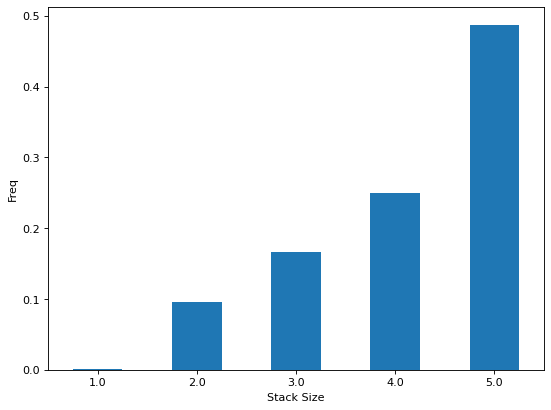

In [30]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
stack1_order = [1.0,2.0,3.0,4.0,5.0]
ax = stack1_own.loc[stack1_order].plot.bar(x='lab', y='val', rot=0)
ax.set_xlabel('Stack Size')
ax.set_ylabel('Freq')
plt.show()

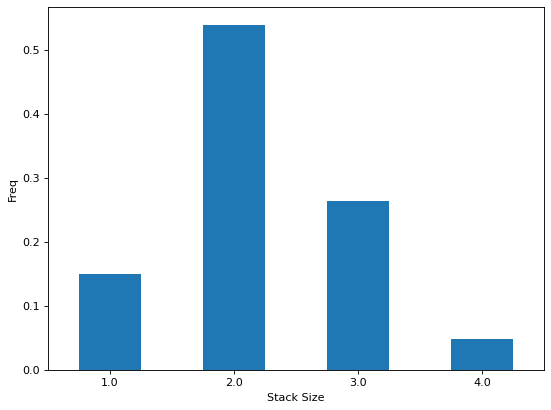

In [31]:
figure(figsize=(8, 6), dpi=80)
stack2_order = [1.0,2.0,3.0,4.0]
ax = stack2_own.loc[stack2_order].plot.bar(x='lab', y='val', rot=0)
ax.set_xlabel('Stack Size')
ax.set_ylabel('Freq')
plt.show()

Based on the visualizations, it looks like 5-man main stacks were utilized by almost half of the lineups in the field. For secondary stacks, 2-mans were the most popular at about 54% followed by 3-mans at 26%.

We can also visualize the stack combinations.

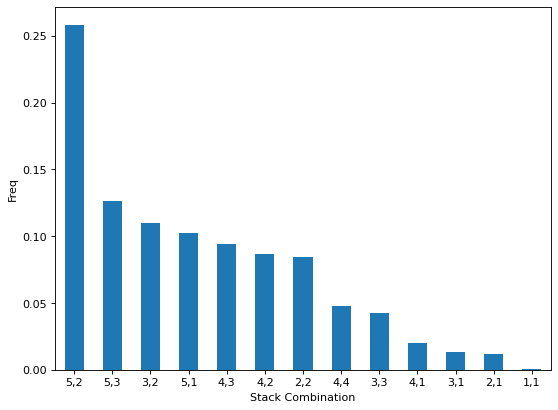

In [32]:
figure(figsize=(8, 6), dpi=80)
stack_combo_own = cleaned_contest['Stack_Combo'].value_counts(normalize=True)
ax = stack_combo_own.plot.bar(x='lab', y='val', rot=0)
ax.set_xlabel('Stack Combination')
ax.set_ylabel('Freq')
plt.show()

Unsurprisingly, 5-2 stack combination was the most popular strategy for this contest.

#### Which teams did winning lineups stack the most?

We will define a winning lineup in this case as a top 1% finish in the contest. This would be the top 98 lineups.

In [33]:
winning_lineups = cleaned_contest.iloc[0:98,] 
winning_stacks1 = winning_lineups['Stack1_Team'].value_counts(normalize=True)
winning_stacks2 = winning_lineups['Stack2_Team'].value_counts(normalize=True)
print(winning_stacks1)
print(winning_stacks2)

LAA    0.806122
NYY    0.122449
BOS    0.040816
COL    0.010204
SEA    0.010204
LAD    0.010204
Name: Stack1_Team, dtype: float64
LAD    0.285714
LAA    0.173469
BOS    0.142857
NYY    0.122449
NYM    0.091837
COL    0.051020
SD     0.051020
SEA    0.030612
CHC    0.030612
SF     0.020408
Name: Stack2_Team, dtype: float64


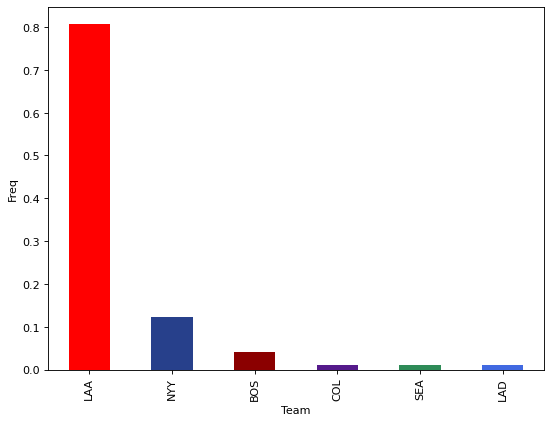

In [34]:
figure(figsize=(8, 6), dpi=80)
ax = winning_stacks1.plot.bar(x='lab', y='val', color=['#FF0000','#27408B','#8B0000','#551A8B','#2E8B57','#4169E1'])
ax.set_xlabel('Team')
ax.set_ylabel('Freq')
plt.show()

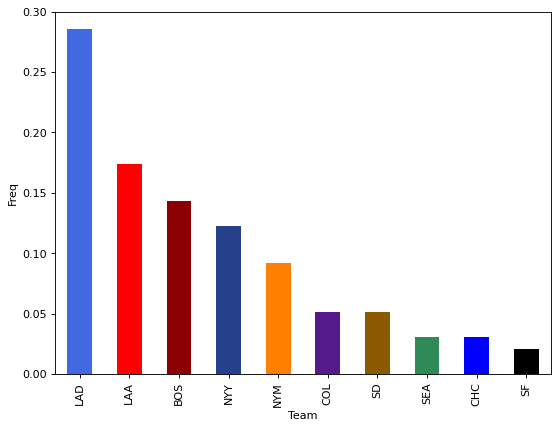

In [35]:
figure(figsize=(8, 6), dpi=80)
ax = winning_stacks2.plot.bar(x='lab', y='val', color=['#4169E1','#FF0000','#8B0000','#27408B','#FF8000','#551A8B','#8B5A00','#2E8B57','#0000FF','#000000'])
ax.set_xlabel('Team')
ax.set_ylabel('Freq')
plt.show()

The winning lineups primarily played a main stack of LA Angels while the secondary stacks were more spread between teams like the Dodgers, Angels, Red Sox, etc.

One other interesting thing would be to look at the stack combinations for these winning lineups.

In [36]:
winning_combos = winning_lineups['Stack_Combo'].value_counts(normalize=True)
print(winning_combos)

5,2    0.438776
5,1    0.193878
5,3    0.163265
4,2    0.051020
4,4    0.040816
4,3    0.020408
4,1    0.020408
2,2    0.020408
3,3    0.020408
3,1    0.010204
3,2    0.010204
2,1    0.010204
Name: Stack_Combo, dtype: float64


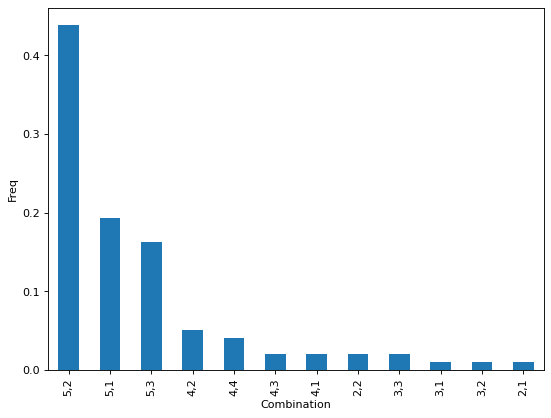

In [37]:
figure(figsize=(8, 6), dpi=80)
ax = winning_combos.plot.bar(x='lab', y='val')
ax.set_xlabel('Combination')
ax.set_ylabel('Freq')
plt.show()

Again, 5-2 was the most popular stack combination among the winning lineups with other combinations of 5-man stacks performing well too.

#### What are the tendencies of 150-maxers vs the field in this contest?

In theory, the 150-maxers are "professionals" playing more theoretically optimal strategies. We can compare their strategy to that of the field. We will seperate these users into their own dataframe.

In [38]:
user_entry_count = cleaned_contest['EntryName'].value_counts()
maxers_150 = user_entry_count[user_entry_count == 150]
print(len(maxers_150))
print(maxers_150)

21
ihbrown3                150
ocdobv                  150
garnes222               150
scott12e12              150
dannyoms                150
Terper8                 150
Nitram99                150
DFS_HofbrauKing         150
JBCJBCJBC               150
l800Eddie               150
craftylefty             150
chris41658              150
lox262                  150
cowboys282              150
bulldog0202             150
BRORANNOSAURUS_FLEX     150
youdacao                150
KevinRob2128            150
bric75                  150
giantsquid              150
UglyLovely              150
Name: EntryName, dtype: int64


There are 21 users in this contest who entered 150 lineups. We can create a dataframe consisting of only these users.

In [39]:
maxers_df = cleaned_contest[cleaned_contest['EntryName'].isin(maxers_150.index)]
print(len(maxers_df))
maxers_df.head()

3150


,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,FLEX8_Order,FLEX9_Order,FLEX10_Order,Dupes,Stack1_Size,Stack1_Team,Stack2_Size,Stack2_Team,Stack_Combo,Stack_Combo_Team
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,5,6,9,1,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,5,1,9,1,5.0,LAA,1.0,BOS,"5,1","LAA:5, BOS:1"
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,6,6,8,1,5.0,LAA,2.0,NYM,"5,2","LAA:5, NYM:2"
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,7,5,9,1,5.0,LAA,3.0,LAD,"5,3","LAA:5, LAD:3"
5,6,bric75,194.05,"Jordan Montgomery,Kyle Freeland,Shohei Ohtani,...",Jordan Montgomery,Kyle Freeland,Shohei Ohtani,Rafael Devers,Mike Trout,J.D. Martinez,...,3,6,8,1,5.0,BOS,2.0,LAA,"5,2","BOS:5, LAA:2"


We now have a data frame including 3,150 rows (150*21) only including 150-max users. We can create another dataframe excluding these users that we will call `field`.

In [40]:
cleaned_contest2 = cleaned_contest.copy()
field = cleaned_contest2[~cleaned_contest2.EntryName.isin(maxers_150.index)]
print(len(field))
field.head()

6646


,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,FLEX8_Order,FLEX9_Order,FLEX10_Order,Dupes,Stack1_Size,Stack1_Team,Stack2_Size,Stack2_Team,Stack_Combo,Stack_Combo_Team
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,9,7,SP,1,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
10,11,July40521,186.20,"Jordan Montgomery,George Kirby,Shohei Ohtani,M...",Jordan Montgomery,George Kirby,Shohei Ohtani,Mike Trout,Francisco Lindor,Gleyber Torres,...,5,1,6,1,4.0,LAA,2.0,NYM,"4,2","LAA:4, NYM:2"
11,12,rrod133,185.95,"George Kirby,Kyle Freeland,Aaron Judge,Shohei ...",George Kirby,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Freddie Freeman,...,4,6,9,1,5.0,LAA,2.0,NYY,"5,2","LAA:5, NYY:2"
18,19,Chill70,183.15,"Jordan Montgomery,Shohei Ohtani,Mike Trout,Ant...",Jordan Montgomery,Shohei Ohtani,Mike Trout,Anthony Rendon,Jesse Winker,Jared Walsh,...,6,9,SP,1,5.0,LAA,1.0,BOS,"5,1","LAA:5, BOS:1"
22,23,youngwildndavid,182.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Giancarlo Stanton,Mike Trout,...,6,8,9,1,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"


We can now analyze the differences in strategies between these two user groups. We will mainly focus on looking at each groups stack combinations.

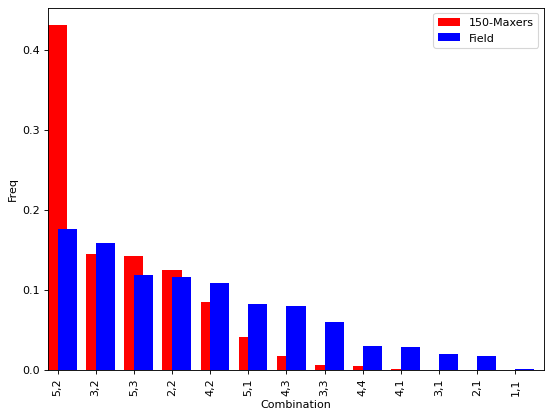

In [60]:
maxers_df_combos = maxers_df['Stack_Combo'].value_counts(normalize=True)
field_combos = field['Stack_Combo'].value_counts(normalize=True)
figure(figsize=(8, 6), dpi=80)
ax = maxers_df_combos.plot.bar(color='red',label='150-Maxers',width=0.5)
field_combos.plot.bar(align='edge',color='blue',label='Field', width=0.5,ax=ax)
ax.set_xlabel('Combination')
ax.set_ylabel('Freq')
ax.legend()
plt.show()

Similar to the winning lineups stack combination distribution, 150-maxers use the 5-2 stack strategy at over twice the rate of the field. We can also see that all 150-maxers employ a stacking strategy of some sort as none have bare 3-man or 2-man stacks. 

## Conclusion

In this project, we downloaded and cleaned a raw Draftkings CSV file for analysis. We primarily looked at different stacking strategies and which worked the best for this specific contest. We also looked at how max entry players stacking strategy differed from that of the rest of the field. This analysis can be used to develop winning strategies when playing DraftKings MLB contests.

Further analysis could include analysis incorporating salary and ownership. This code can also be wrapped in functions to generate quick analysis for any MLB slate to be analyzed. We can see what strategy worked best for this contest, but it would be interesting to see which strategies work best across time and to try to reverse engineer professional players strategies.